<a href="https://colab.research.google.com/github/Islam-I-Abdelmajied/Brain-Tumor-Classification/blob/master/Change_data_pool_ratio_Brain_Tumor_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data preprocessing 

In [1]:
!pip install wget
!pip install mat73

  Created wheel for wget: filename=wget-3.2-cp36-none-any.whl size=9682 sha256=375d73c70330dab7a85123ae62beb63489cd56fb18f12ea6aa4f9e7f0151234c
  Stored in directory: /root/.cache/pip/wheels/40/15/30/7d8f7cea2902b4db79e3fea550d7d7b85ecb27ef992b618f3f
Successfully built wget
  Created wheel for mat73: filename=mat73-0.35-cp36-none-any.whl size=3401 sha256=11cd67e366d802c8e331d1fd73b4541c16c7287a27e3c5c134ce7bf410935731
  Stored in directory: /root/.cache/pip/wheels/16/60/66/04d98331f8f42fa55b475d119f2804d7203225223d356be499
Successfully built mat73


### 1) Extract data

In [2]:
import wget
from tqdm import tqdm
url ='https://ndownloader.figshare.com/articles/1512427/versions/5'
wget.download(url)
import os
os.rename('1512427.zip', 'mat_data.zip')



import zipfile
with zipfile.ZipFile("mat_data.zip","r") as zip_ref:
    zip_ref.extractall("datasetzipfiles")
os.remove('/content/mat_data.zip')


os.remove('/content/datasetzipfiles/README.txt')
os.remove('/content/datasetzipfiles/cvind.mat')

zipfiles = os.listdir('/content/datasetzipfiles')


for file in tqdm(zipfiles):
    with zipfile.ZipFile('/content/datasetzipfiles/'+file,"r") as zip_ref:
        zip_ref.extractall("/content/dataset")
    os.remove('/content/datasetzipfiles/'+file)
os.rmdir('/content/datasetzipfiles')


100%|██████████| 4/4 [00:27<00:00,  6.97s/it]


In [3]:
#Check data
mat_dataset = os.listdir('/content/dataset')
print(len(mat_dataset))
print(mat_dataset[0])

3064
2654.mat


In [0]:
import torch
import torchvision
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
from torchvision import transforms, utils, models

import numpy as np 
import PIL
import os

import mat73
from tqdm import tqdm
import matplotlib.pyplot as plt 
%matplotlib inline
plt.ion()

## Data loading

In [0]:
########### try using balanced classes 708 930 1000 ###########

### 2) Transform data

In [8]:
def mat_to_list(dir):
    files = os.listdir(dir)
    data_struct = []
    data_labels = []

    for file in tqdm(files):
        data_dict = mat73.loadmat(dir + file)
        data_struct.append([np.float32(data_dict['cjdata']['image']), int(data_dict['cjdata']['label'])-1])
        data_labels.append( int(data_dict['cjdata']['label'])-1)
    return data_struct, data_labels

dataset, data_labels= mat_to_list('/content/dataset/')



100%|██████████| 3064/3064 [00:22<00:00, 133.84it/s]


In [0]:
def data_pool_mat_to_list(dir, threshold=None):
    files = os.listdir(dir)
    data_struct = []
    data_labels = []
    counter = 0

    for file in tqdm(files):
        data_dict = mat73.loadmat(dir + file)
        if int(data_dict['cjdata']['label'])-1 != 1:
            data_struct.append([np.float32(data_dict['cjdata']['image']), int(data_dict['cjdata']['label'])-1])
            data_labels.append( int(data_dict['cjdata']['label'])-1)
        elif int(data_dict['cjdata']['label'])-1 == 1 and counter <= threshold:
            data_struct.append([np.float32(data_dict['cjdata']['image']), int(data_dict['cjdata']['label'])-1])
            data_labels.append( int(data_dict['cjdata']['label'])-1)
            counter += 1
        else:
            continue 

    return data_struct, data_labels

In [12]:
dataset, data_labels= data_pool_mat_to_list('/content/dataset/', 1000)

100%|██████████| 3064/3064 [00:21<00:00, 140.54it/s]


In [13]:
len(dataset)

2639

In [14]:
len(data_labels)

2639

In [15]:
from collections import Counter################################
Counter(data_labels) ##########################################

Counter({0: 708, 1: 1001, 2: 930})

In [0]:
# dataset = mat_to_list('/content/dataset/')
# batch_size = 16
# test_size = .2
# valid_size = .2
# shuffle_dataset = True
# seed= 69

# dataset_size = len(dataset)
# train_split = int(np.floor(dataset_size - dataset_size * (test_size + valid_size) ))
# test_split = int(np.floor(train_split + dataset_size * test_size ))

# indices = list(range(dataset_size))
# if shuffle_dataset :
#     np.random.seed(seed)
#     np.random.shuffle(indices)

# train_indices, test_indices, valid_indices = indices[:train_split], indices[train_split: test_split], indices[test_split:]

100%|██████████| 3064/3064 [00:26<00:00, 115.76it/s]


In [0]:
# len(dataset)

3064

In [0]:
# train_dataset = dataset[:train_split]
# test_dataset = dataset[train_split: test_split]
# valid_dataset = dataset[test_split:]

In [0]:
# print(len(train_dataset))
# print(len(test_dataset))
# print(len(valid_dataset))

1838
612
614


In [0]:
class BrainTumorDataset(Dataset):
    def __init__(self, dir, transform=None):

        self.files = os.listdir(dir)
        self.data_struct = []
        self.transform = transform

        for file in tqdm(self.files):
            data_dict = mat73.loadmat(dir + file)
            self.data_struct.append([np.float32(data_dict['cjdata']['image']), int(data_dict['cjdata']['label'])-1])
        
    def __len__(self):
        return len(self.data_struct)

    def __getitem__(self, index):

        image = PIL.Image.fromarray(self.data_struct[index][0])


        if self.transform:
            image = self.transform(image)

        label = self.data_struct[index][1]

        sample = image , label
        return sample

In [0]:
class BrainTumorWithSplitDataset(Dataset):
    def __init__(self, dir, threshold=None, transform=None):

        self.files = os.listdir(dir)
        self.data_struct = []
        self.transform = transform
        self.counter = 0

        for file in tqdm(self.files):
            data_dict = mat73.loadmat(dir + file)
            if int(data_dict['cjdata']['label'])-1 != 1:
                self.data_struct.append([np.float32(data_dict['cjdata']['image']), int(data_dict['cjdata']['label'])-1])
            elif int(data_dict['cjdata']['label'])-1 == 1 and self.counter < threshold:
                self.data_struct.append([np.float32(data_dict['cjdata']['image']), int(data_dict['cjdata']['label'])-1])
                self.counter += 1
        
    def __len__(self):
        return len(self.data_struct)

    def __getitem__(self, index):

        image = PIL.Image.fromarray(self.data_struct[index][0])


        if self.transform:
            image = self.transform(image)

        label = self.data_struct[index][1]

        sample = image , label
        return sample

In [0]:
data_transform = transforms.Compose([transforms.Resize(256),
                                     transforms.ToTensor()])

In [0]:
dataset = BrainTumorDataset('/content/dataset/', transform=data_transform)

In [20]:
dataset = BrainTumorWithSplitDataset('/content/dataset/', threshold=1000, transform=data_transform)

100%|██████████| 3064/3064 [00:21<00:00, 141.61it/s]


### 3) Load data

In [0]:

batch_size = 32
test_size = .2
valid_size = .2
shuffle_dataset = True
seed= 69

dataset_size = len(dataset)
train_split = int(np.floor(dataset_size - dataset_size * (test_size + valid_size) ))
test_split = int(np.floor(train_split + dataset_size * test_size ))

indices = list(range(dataset_size))
if shuffle_dataset :
    np.random.seed(seed)
    np.random.shuffle(indices)

train_indices, test_indices, valid_indices = indices[:train_split], indices[train_split: test_split], indices[test_split:]

train_sampler = SubsetRandomSampler(train_indices)
test_sampler = SubsetRandomSampler(test_indices)
valid_sampler = SubsetRandomSampler(valid_indices)

train_loader = DataLoader(dataset, batch_size=batch_size, sampler=train_sampler)
test_loader = DataLoader(dataset, batch_size=batch_size, sampler=test_sampler)
valid_loader = DataLoader(dataset, batch_size=batch_size, sampler=valid_sampler)

In [0]:

batch_size = 32
test_size = 0
valid_size = 0.3
shuffle_dataset = True
seed= 69

dataset_size = len(dataset)
train_split = int(np.floor(dataset_size - dataset_size * (test_size + valid_size) ))
test_split = int(np.floor(train_split + dataset_size * test_size ))

indices = list(range(dataset_size))
if shuffle_dataset :
    np.random.seed(seed)
    np.random.shuffle(indices)

train_indices, test_indices, valid_indices = indices[:train_split], indices[train_split: test_split], indices[test_split:]

train_sampler = SubsetRandomSampler(train_indices)
test_sampler = SubsetRandomSampler(test_indices)
valid_sampler = SubsetRandomSampler(valid_indices)

train_loader = DataLoader(dataset, batch_size=batch_size, sampler=train_sampler)
test_loader = DataLoader(dataset, batch_size=batch_size, sampler=test_sampler)
valid_loader = DataLoader(dataset, batch_size=batch_size, sampler=valid_sampler)

In [0]:
# mean = 0.
# std = 0.
# nb_samples = 0.
# for data in train_loader:
#     batch_samples = data.size(0)
#     data = data.view(batch_samples, data.size(1), -1)
#     mean += data.mean(2).sum(0)
#     std += data.std(2).sum(0)
#     nb_samples += batch_samples

# mean /= nb_samples
# std /= nb_samples

torch.Size([32, 1, 256, 256])
tensor(2)
tensor([2, 2, 0, 2, 2, 1, 0, 2, 1, 2, 2, 2, 0, 1, 0, 1, 0, 1, 2, 1, 2, 1, 0, 2,
        1, 2, 2, 2, 1, 2, 0, 1])


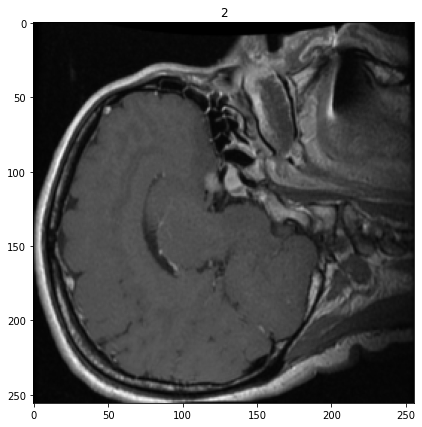

In [25]:
images, labels = next(iter(train_loader))
fig= plt.figure(figsize=(7, 7))
print(images.shape)
print(labels[3])
print(labels)
plt.imshow(images[0][0], cmap='gray')
plt.title(int(labels[0]))
plt.show()

In [26]:
###############################################################
print(len(train_indices))
print(len(test_indices))
print(len(valid_indices))

1846
0
792


In [0]:
##################### Network#################

In [0]:
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import copy
import time

In [28]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
device

'cuda:0'

In [29]:
dataset_sizes = {'train': len(train_indices), 'val': len(valid_indices)}
dataset_sizes

{'train': 1846, 'val': 792}

In [0]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
                dataloader = train_loader
            else:
                model.eval()   # Set model to evaluate mode
                dataloader = valid_loader

            running_loss = 0.0
            running_corrects = 0


            # Iterate over data.
            for inputs, labels in dataloader:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [0]:
# def visualize_model(model, num_images=6):
#     was_training = model.training
#     model.eval()
#     images_so_far = 0
#     fig = plt.figure()

#     with torch.no_grad():
#         for i, (inputs, labels) in enumerate(valid_loader):
#             inputs = inputs.to(device)
#             labels = labels.to(device)

#             outputs = model(inputs)
#             _, preds = torch.max(outputs, 1)

#             for j in range(inputs.size()[0]):
#                 images_so_far += 1
#                 ax = plt.subplot(num_images//2, 2, images_so_far)
#                 ax.axis('off')
#                 ax.set_title('predicted: {}'.format(class_names[preds[j]]))
#                 imshow(inputs.cpu().data[j])

#                 if images_so_far == num_images:
#                     model.train(mode=was_training)
#                     return
#         model.train(mode=was_training)

In [0]:
network = models.vgg11_bn(pretrained=False)
num_features = network.classifier[6].in_features
###########################################  {{here!!}}
network.classifier[6] = nn.Linear(num_features, 3)
###########################################  {{here!!}}
network.features[0] = nn.Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
network = network.to(device)

In [31]:
resnet50_model = models.resnet50(pretrained=True)
resnet50_model.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
resnet50_model.fc = nn.Linear(in_features=2048, out_features=3, bias=True)
resnet50_model.to(device)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/checkpoints/resnet50-19c8e357.pth


ResNet(
  (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [32]:
from torchsummary import summary

summary(resnet50_model, (1, 256, 256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 128, 128]           3,136
       BatchNorm2d-2         [-1, 64, 128, 128]             128
              ReLU-3         [-1, 64, 128, 128]               0
         MaxPool2d-4           [-1, 64, 64, 64]               0
            Conv2d-5           [-1, 64, 64, 64]           4,096
       BatchNorm2d-6           [-1, 64, 64, 64]             128
              ReLU-7           [-1, 64, 64, 64]               0
            Conv2d-8           [-1, 64, 64, 64]          36,864
       BatchNorm2d-9           [-1, 64, 64, 64]             128
             ReLU-10           [-1, 64, 64, 64]               0
           Conv2d-11          [-1, 256, 64, 64]          16,384
      BatchNorm2d-12          [-1, 256, 64, 64]             512
           Conv2d-13          [-1, 256, 64, 64]          16,384
      BatchNorm2d-14          [-1, 256,

In [0]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(resnet50_model.parameters(), lr=0.003, momentum=0.9)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [0]:
train = train_model(resnet50_model, criterion, optimizer, exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
train Loss: 0.5426 Acc: 0.7692
val Loss: 0.6141 Acc: 0.7551

Epoch 1/24
----------
train Loss: 0.2168 Acc: 0.9187
val Loss: 0.1737 Acc: 0.9343

Epoch 2/24
----------
train Loss: 0.0900 Acc: 0.9680
val Loss: 0.1366 Acc: 0.9419

Epoch 3/24
----------
train Loss: 0.0846 Acc: 0.9702
val Loss: 0.1643 Acc: 0.9331

Epoch 4/24
----------
train Loss: 0.0361 Acc: 0.9908
val Loss: 0.1194 Acc: 0.9571

Epoch 5/24
----------
train Loss: 0.0192 Acc: 0.9940
val Loss: 0.0510 Acc: 0.9823

Epoch 6/24
----------
train Loss: 0.0163 Acc: 0.9962
val Loss: 0.1576 Acc: 0.9520

Epoch 7/24
----------
train Loss: 0.0036 Acc: 0.9989
val Loss: 0.0678 Acc: 0.9735

Epoch 8/24
----------
train Loss: 0.0082 Acc: 0.9978
val Loss: 0.0648 Acc: 0.9785

Epoch 9/24
----------
train Loss: 0.0030 Acc: 1.0000
val Loss: 0.0640 Acc: 0.9773

Epoch 10/24
----------
train Loss: 0.0047 Acc: 0.9995
val Loss: 0.0768 Acc: 0.9722

Epoch 11/24
----------
train Loss: 0.0040 Acc: 1.0000
val Loss: 0.0676 Acc: 0.9747

Ep

In [0]:
# class Normalize(transforms.Normalize):
#     super(self).__init__():



# # class MyDataset(Dataset):
# #     def __init__(self):
# #         self.data = torch.randn(100, 3, 24, 24)
        
# #     def __getitem__(self, index):
# #         x = self.data[index]
# #         return x

# #     def __len__(self):
# #         return len(self.data)
    

# # dataset = MyDataset()
# # loader = DataLoader(
# #     dataset,
# #     batch_size=10,
# #     num_workers=1,
# #     shuffle=False
# # )


# mean = 0.
# std = 0.
# nb_samples = 0.
# for data in loader:
#     batch_samples = data.size(0)
#     data = data.view(batch_samples, data.size(1), -1)
#     mean += data.mean(2).sum(0)
#     std += data.std(2).sum(0)
#     nb_samples += batch_samples

# mean /= nb_samples
# std /= nb_samples

In [0]:
from torchsummary import summary

summary(network, (1, 128, 128), -1, 'cuda')

RuntimeError: ignored